# CUNYSPS DATA698 Fall 2019 Research Project

# Title: NYC Traffic Fare Levels and Volume

# Author: Jonathan Hernandez

This project looks at NYC hourly volume of vehicles of serveral NYC bridges and tunnels specifed per hour.

Actual historical fare prices will be appened to the dataset at first and then using different regression algorithms, find the one that best predicts traffic volume.

Once, that is completed, simulated fare prices will also be appended to the dataset and using the best regression algorithm, predict volume usage.

The hightest simulated fare value with the smallest total volume will be used and as a simple simulation, that fare price is the best fare to use across all NYC bridges and tunnels.

This result and analysis can hopefully show that a high fare price should also encourage commuters to use alternative modes of transportation and reduce CO2 emissions and accidents.

In [1]:
import warnings
import pandas as pd
import numpy as np
import re
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore") #suppress warnings

## Getting the data

Importing the dataset of toll and bridge volume in NYC staring from 2010


In [2]:
nyc_traffic_csv = "hourly-traffic-on-metropolitan-transportation-authority-mta-bridges-and-tunnels-beginning-2010.csv"
nyc_traffic_data = pd.read_csv(nyc_traffic_csv)

nyc_traffic_data.columns

Index(['Plaza ID', 'Date', 'Hour', 'Direction', '# Vehicles - ETC (E-ZPass)',
       '# Vehicles - Cash/VToll'],
      dtype='object')

Let's rename the columns Plaza ID and the vehicle columns to have underscores for better readabaility and avoid having errors or issues using spaces.

In [3]:
nyc_traffic_data.rename(columns={"Plaza ID": "plazaID",
                                 "# Vehicles - ETC (E-ZPass)": "n_vehicles_ezpass",
                                 "# Vehicles - Cash/VToll": "n_vehicles_cash"}, inplace=True)

In [4]:
nyc_traffic_data.columns

Index(['plazaID', 'Date', 'Hour', 'Direction', 'n_vehicles_ezpass',
       'n_vehicles_cash'],
      dtype='object')

The Plaza ID's can be mapped based on the toll plaza location.

There is a different mapping 

For example: 

Replace Plaza Id's with actual bridge/tunnel names

Per the MTA_Hourly Traffic Bridge Tunnel_Data Dictionary.pdf values:

1 -11 are the original historical values before tolling switchover dates

21 - 30 are the values after the open road tolling switch over date (around 2017)

## Data Preprocessing

1. replace the Plaza ID's with actual bridge/tunnel names

2. Remove the time in the Date Column as there is a column already specifying the hour and format the date

3. load the fare prices of several bridges throughout 2010-2019

4. Append these fare prices to the dataset in a column called 'fare_price'

In [5]:
nyc_bridges_tolls_names = {1: 'TBX', 2: 'TBM', 3: 'BWB', 4: 'HHB', 5: 'MPB',
                           6: 'CBB', 7: 'QMT', 8: 'HCT', 9: 'TNB', 11: 'VNB',
                           21: 'TBX', 22: 'TBM', 23: 'BWB', 24: 'HHB', 25: 'MPB',
                           26: 'CBB', 27: 'QMT', 28: 'HCT', 29: 'TNB', 30: 'VNB'}
nyc_traffic_data['plazaID'] = [nyc_bridges_tolls_names[item] for item in nyc_traffic_data['plazaID']]

In [6]:
# remove the time after "T"
nyc_traffic_data['Date'] = [re.sub('T.*', "", date_time) for date_time in nyc_traffic_data['Date']]

# format the date
nyc_traffic_data['Date'] = pd.to_datetime(nyc_traffic_data['Date'])

In [7]:
# load the fare prices for each bridge/tunnel
# data comes from the wikipedia of each bridge
vnb = pd.read_csv('vnb_fare_history.csv')
rfk = pd.read_csv('rfk_fare_history.csv')
bwt = pd.read_csv('bwt_fare_history.csv')
qmt = pd.read_csv('qmt_fare_history.csv')
bbt = pd.read_csv('bbt_fare_history.csv')
tnb = pd.read_csv('tnb_fare_history.csv')
vnb = pd.read_csv('vnb_fare_history.csv')

In [8]:
# print them out beginning from 2010
print(rfk[["Years", "Toll"]][14:])
print(vnb[["Years", "Toll"]][14:])
print(bwt[["Years", "Toll"]][14:])
print(qmt[["Years", "Toll"]][14:])
print(bbt[["Years", "Toll"]][14:])
print(tnb[["Years", "Toll"]][14:])

                   Years   Toll
14             2010–2015  $6.50
15             2015–2017  $8.00
16             2017–2019  $8.50
17  April 2019 – present  $9.50
                          Years    Toll
14                    2010–2015  $13.00
15                    2015–2017  $16.00
16                    2017–2019  $17.00
17  March 2019 – present[when?]  $19.00
                   Years   Toll
14             2010–2015  $6.50
15             2015–2017  $8.00
16             2017–2019  $8.50
17  April 2019 – present  $9.50
                   Years   Toll
14             2010–2015  $6.50
15             2015–2017  $8.00
16             2017–2019  $8.50
17  April 2019 – present  $9.50
                   Years   Toll
14             2010–2015  $6.50
15             2015–2017  $8.00
16             2017–2019  $8.50
17  April 2019 – present  $9.50
                 Years   Toll
14           2010–2015  $6.50
15           2015–2017  $8.00
16           2017–2019  $8.50
17  April 2019–present  $9.50


We see that for every bridge except for the Verranzo-Narrows Bridge, all other bridges were about \\$6.50 in 2010 and went up the same value up to \\$9.50

For 2010 to 2015 make a new column fare_price set to 6.50 except for the verranzo narrows bridge

In [9]:
# Empty column
nyc_traffic_data['fare_price'] = ""

# Query to select all rows with hourly results that came from 2010 to 2019 inclusive and not from
# The Verranzo-Narrows Bridge and set the fare_price to 6.50
nyc_traffic_data['year'] = nyc_traffic_data['Date'].dt.year

nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2010, 2014)), 'fare_price'] = 6.50

nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2015, 2016)), 'fare_price'] = 8.00

nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2017, 2019)), 'fare_price'] = 9.50

Now do the same but for the Verranzo Narrows Bridge

In [10]:
nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2010, 2014)), 'fare_price'] = 13.00

nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2015, 2016)), 'fare_price'] = 16.00

nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2017, 2019)), 'fare_price'] = 19.00

This dataset now contains the fare prices of each bridge and the number of vehicles entering Inbound or Outboud per hour from 2010-2019

## Exploratory Data Analysis

There is a python module called pandas_profiling that can take a datset and do all sorts of EDA in a one-liner.

Let's get more insight on our data

In [11]:
pandas_profiling.ProfileReport(nyc_traffic_data[nyc_traffic_data.columns.difference(['year', 'fare_price'])], style={'full_width':True})

In [12]:
# save the output to .html
profile = pandas_profiling.ProfileReport(nyc_traffic_data[nyc_traffic_data.columns.difference(['year', 'fare_price'])], style={'full_width':True})
profile.to_file(output_file="NYC traffic data EDA.html")

Based on this EDA, we see the following

- There are 1467219 rows with 7 columns
- No missing data
- over 2000 duplicate rows. The profile_reporting function sees this as several columns as duplicate due to several measurements having the same toll plaza abbreviation.
- There were much smaller measurements aroud mid 2017
- There are 10 unique toll plazas
- A pearson correlation shows positive correlation and strong ones against the different types of toll payments (cash vs EZ-pass)

Let's also see how much traffic occurs for each hour for each bridge

Now let us do some data modeling and implement some algorithms.

As we are trying to create a optimization model that minimizes fare prices but can maximize revenue,
this will be a regression problem. We are not classifying anything in this case.

We'll look at simple linear regression, elastic net and then Random Forest and use the algorithm with the smallest RMSE to see which model we'll use for simulated fares

## Training ML Models for Predicting Vehicle Volume

In [13]:
# Multiple Linear Regression approach
# Let's first encode the Plaza ID and Direction for the sole purpose of running the ML algorithms such as
# Multple linear regression, elastic Net and RandomForest

# encoding the Plaza ID and Direction
encoder_plazaID = preprocessing.LabelEncoder()
encoder_fit = encoder_plazaID.fit(nyc_traffic_data['plazaID'])
plazaID_temp = encoder_plazaID.transform(nyc_traffic_data['plazaID']) # temp location to store one hot encoding of plaza ID for fitting models
nyc_traffic_data['plazaID'] = plazaID_temp

encoder_direction = preprocessing.LabelEncoder()
encoder_direction_fit = encoder_direction.fit(nyc_traffic_data['Direction'])
direction_temp = encoder_direction.transform(nyc_traffic_data['Direction'])
nyc_traffic_data['Direction'] = direction_temp

In [14]:
# explanatory variables
data = nyc_traffic_data[["plazaID", "Hour", "year", "Direction", "fare_price"]]

# response variable
y = nyc_traffic_data["n_vehicles_ezpass"]


# training and test split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3)

In [15]:
# Fit a multiple linear regression
lm_ezpass = linear_model.LinearRegression()
lm_ezpass_fit = lm_ezpass.fit(X_train,y_train)
print("RMSE of Multiple Linear Regression: ", round(mean_squared_error(y_test, lm_ezpass_fit.predict(X_test))**.5, 2))
print("MAE of Multiple Linear Regression: ", round(mean_absolute_error(y_test, lm_ezpass_fit.predict(X_test)), 2))

RMSE of Multiple Linear Regression:  1032.29
MAE of Multiple Linear Regression:  789.06


In [16]:
# Elastic Net algorithm (Using both LASSO and Ridge Regression)
en_ezpass = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.5)
en_ezpass_fit = en_ezpass.fit(X_train, y_train)
print("RMSE of Elastic Net: ", round(mean_squared_error(y_test, en_ezpass_fit.predict(X_test))**.5, 2))
print("MAE of Elastic Net: ", round(mean_absolute_error(y_test, en_ezpass_fit.predict(X_test)), 2))

RMSE of Elastic Net:  1034.27
MAE of Elastic Net:  791.68


In [17]:
# Random forest of 100 trees
rf_ezpass = RandomForestRegressor(n_estimators=100)
rf_ezpass_fit = rf_ezpass.fit(X_train, y_train)

In [18]:
print("RMSE of Random Forest of 100 trees: ", round(mean_squared_error(y_test, rf_ezpass_fit.predict(X_test))**.5, 2))
print("MAE of Random Forest Model: ", round(mean_absolute_error(y_test, rf_ezpass_fit.predict(X_test)), 2))
print
rf_importances = list(rf_ezpass_fit.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(nyc_traffic_data.columns, rf_importances)]

[print('Feature: {:10} Importance: {}'.format(*pair)) for pair in feature_importances]

RMSE of Random Forest of 100 trees:  434.31
MAE of Random Forest Model:  257.08
Feature: plazaID    Importance: 0.43
Feature: Date       Importance: 0.4
Feature: Hour       Importance: 0.04
Feature: Direction  Importance: 0.03
Feature: n_vehicles_ezpass Importance: 0.1


[None, None, None, None, None]

Looking at the MAE and RMSE metrics, it seems that a random forest regression approach is best and is what I will be using to predict the number of vehicles paying EZ pass with simulated fares.

## Creating Simulated Fares

Simulated fares will be created from a certain range which will be from [4, 20] dollars in increments of .50 cents

In [19]:
simulated_fares = np.arange(start=4, stop=20.5, step=1)
simulated_fares

array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.,
       17., 18., 19., 20.])

The random forest took a while to run so these set ranges should be okay. 

In [20]:
# create a new variable fare_price_<price> which will be a dataset of predicted vehicle count for a particular price.
# for the verranzo narrows bridge, we'll double the fare as that was the case during 2010-2019

def predict_vehicle_ezpass_sim_price(fareprice):
    vehicle_ezpass_str_var = "vehicle_ezpass_" + str(fareprice)
    nyc_traffic_data[vehicle_ezpass_str_var] = ""
    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2010, 2014)), vehicle_ezpass_str_var] = fareprice

    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2015, 2016)), vehicle_ezpass_str_var] = fareprice

    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] != 'VNB')
                     & (nyc_traffic_data['year'].between(2017, 2019)), vehicle_ezpass_str_var] = fareprice
    
    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2010, 2014)), vehicle_ezpass_str_var] = fareprice * 2

    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2015, 2016)), vehicle_ezpass_str_var] = fareprice * 2

    nyc_traffic_data.loc[(nyc_traffic_data['plazaID'] == 'VNB')
                     & (nyc_traffic_data['year'].between(2017, 2019)), vehicle_ezpass_str_var] = fareprice * 2
    
    data = nyc_traffic_data[["plazaID", "Hour", "year", "Direction", vehicle_ezpass_str_var]]
    # response variable
    y = nyc_traffic_data["n_vehicles_ezpass"]

    # training and test split
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.3)
    rf_ezpass = RandomForestRegressor(n_estimators=100)
    rf_ezpass_fit = rf_ezpass.fit(X_train, y_train)
    print("Completed fareprice", fareprice)
    vehicle_volume = rf_ezpass_fit.predict(data)
    nyc_traffic_data[vehicle_ezpass_str_var] = np.floor(vehicle_volume) # replace the fares with the estimated volume of traffic 

In [21]:
# can take a while to iterate through all values
for i in simulated_fares:
    predict_vehicle_ezpass_sim_price(i)

Completed fareprice 4.0
Completed fareprice 5.0
Completed fareprice 6.0
Completed fareprice 7.0
Completed fareprice 8.0
Completed fareprice 9.0
Completed fareprice 10.0
Completed fareprice 11.0
Completed fareprice 12.0
Completed fareprice 13.0
Completed fareprice 14.0
Completed fareprice 15.0
Completed fareprice 16.0
Completed fareprice 17.0
Completed fareprice 18.0
Completed fareprice 19.0
Completed fareprice 20.0


In [22]:
nyc_traffic_data.columns

Index(['plazaID', 'Date', 'Hour', 'Direction', 'n_vehicles_ezpass',
       'n_vehicles_cash', 'fare_price', 'year', 'vehicle_ezpass_4.0',
       'vehicle_ezpass_5.0', 'vehicle_ezpass_6.0', 'vehicle_ezpass_7.0',
       'vehicle_ezpass_8.0', 'vehicle_ezpass_9.0', 'vehicle_ezpass_10.0',
       'vehicle_ezpass_11.0', 'vehicle_ezpass_12.0', 'vehicle_ezpass_13.0',
       'vehicle_ezpass_14.0', 'vehicle_ezpass_15.0', 'vehicle_ezpass_16.0',
       'vehicle_ezpass_17.0', 'vehicle_ezpass_18.0', 'vehicle_ezpass_19.0',
       'vehicle_ezpass_20.0'],
      dtype='object')

In [23]:
# now with each simulated fare price used to predict vehicle ez pass volume, compare them with the original value
# and see which volume is the smallest.

nyc_traffic_data

,plazaID,Date,Hour,Direction,n_vehicles_ezpass,n_vehicles_cash,fare_price,year,vehicle_ezpass_4.0,vehicle_ezpass_5.0,...,vehicle_ezpass_11.0,vehicle_ezpass_12.0,vehicle_ezpass_13.0,vehicle_ezpass_14.0,vehicle_ezpass_15.0,vehicle_ezpass_16.0,vehicle_ezpass_17.0,vehicle_ezpass_18.0,vehicle_ezpass_19.0,vehicle_ezpass_20.0
0,7,2019-06-29,0,0,3173,655,9.5,2019,2175.0,2133.0,...,2189.0,2137.0,2162.0,2127.0,2199.0,2149.0,2176.0,2181.0,2157.0,2124.0
1,7,2019-06-29,1,0,2056,559,9.5,2019,1331.0,1272.0,...,1302.0,1302.0,1333.0,1323.0,1312.0,1304.0,1305.0,1279.0,1315.0,1347.0
2,7,2019-06-29,2,0,1441,342,9.5,2019,956.0,927.0,...,943.0,997.0,940.0,970.0,995.0,969.0,947.0,973.0,926.0,1010.0
3,7,2019-06-29,3,0,1372,264,9.5,2019,967.0,941.0,...,936.0,952.0,942.0,969.0,959.0,958.0,933.0,944.0,960.0,951.0
4,7,2019-06-29,4,0,1565,327,9.5,2019,1559.0,1554.0,...,1559.0,1561.0,1554.0,1567.0,1571.0,1570.0,1564.0,1558.0,1572.0,1571.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467214,9,2010-01-01,19,0,2675,1152,13,2010,4560.0,4545.0,...,4525.0,4581.0,4583.0,4622.0,4588.0,4566.0,4557.0,4570.0,4568.0,4540.0
1467215,9,2010-01-01,20,0,2580,1086,13,2010,3858.0,3917.0,...,3903.0,3851.0,3884.0,3851.0,3840.0,3876.0,3864.0,3854.0,3889.0,3889.0
1467216,9,2010-01-01,21,0,2302,987,13,2010,3122.0,3153.0,...,3133.0,3144.0,3134.0,3113.0,3156.0,3135.0,3153.0,3160.0,3147.0,3159.0
1467217,9,2010-01-01,22,0,2170,910,13,2010,2687.0,2713.0,...,2690.0,2709.0,2674.0,2682.0,2712.0,2681.0,2674.0,2689.0,2687.0,2700.0


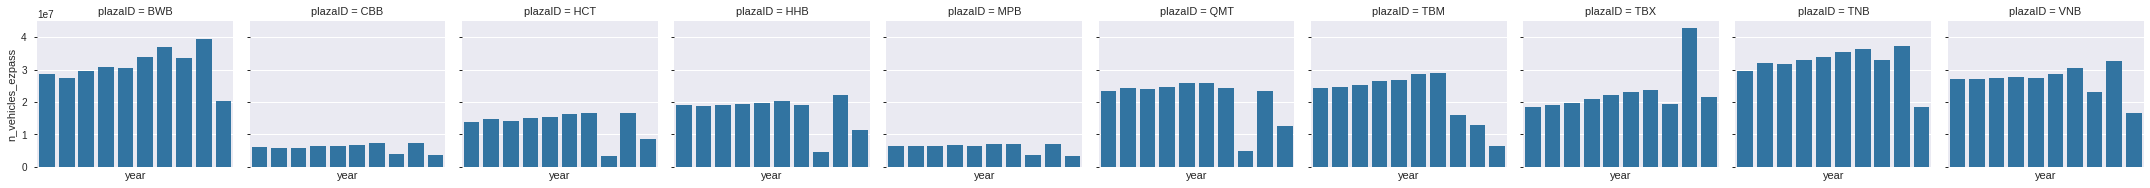

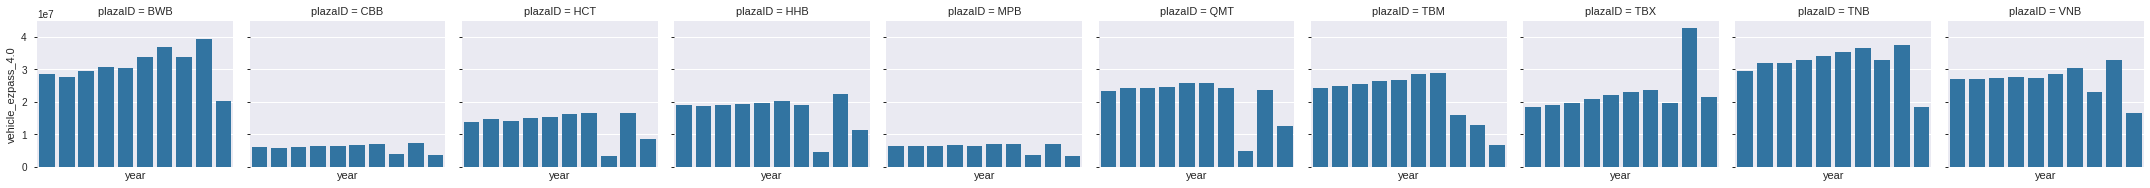

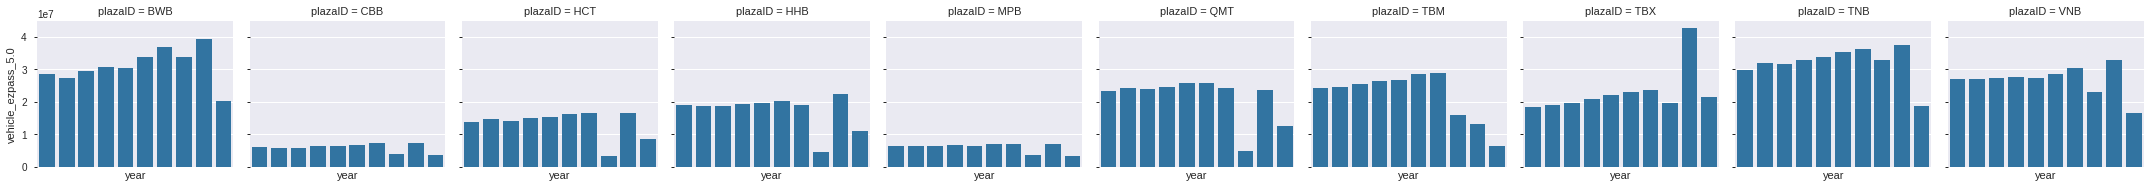

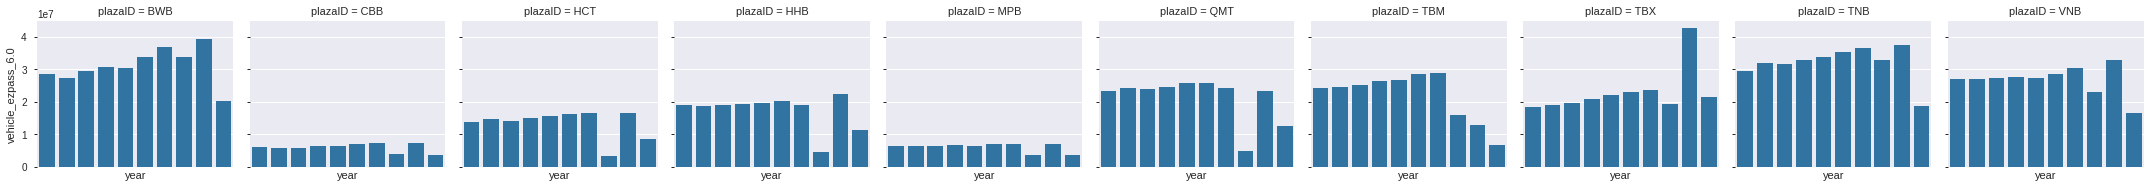

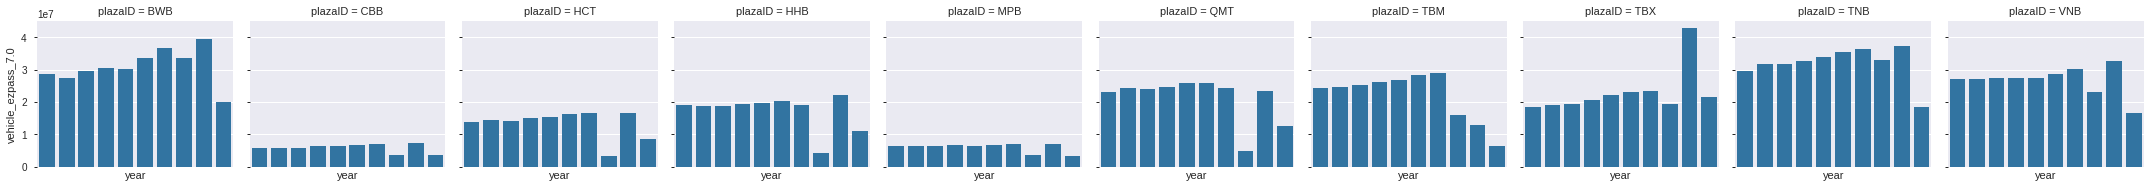

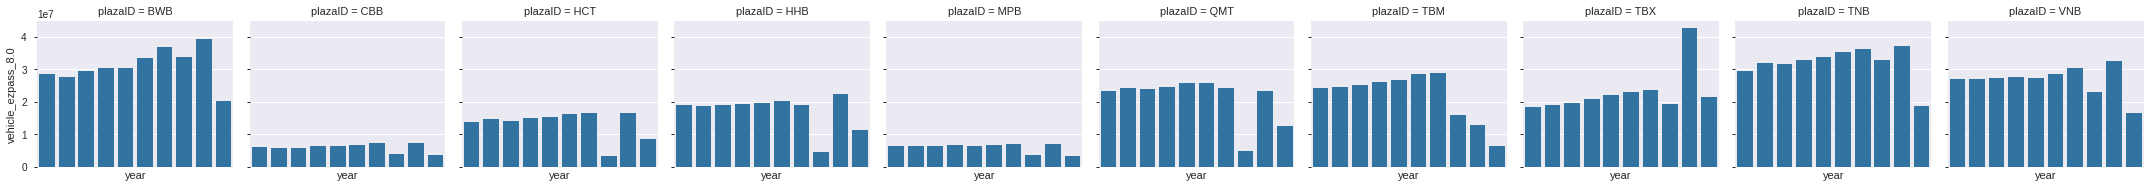

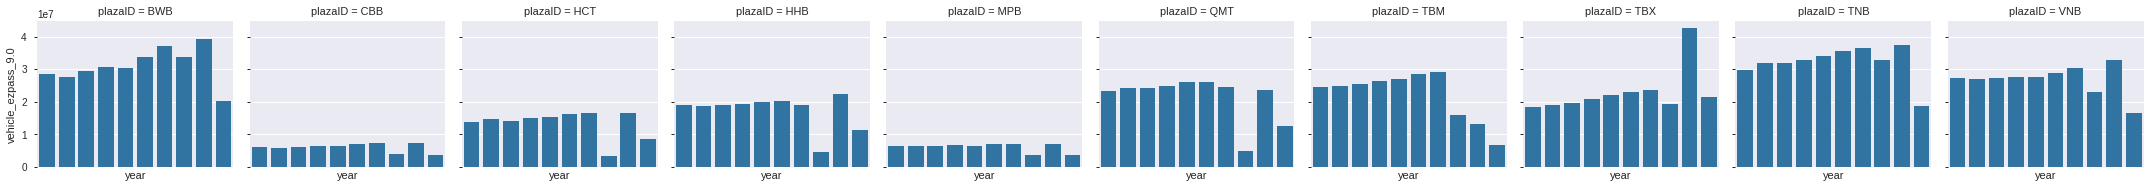

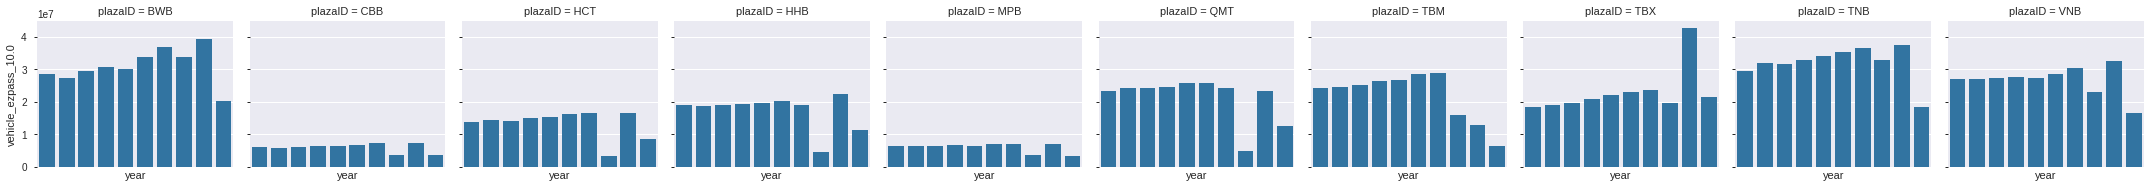

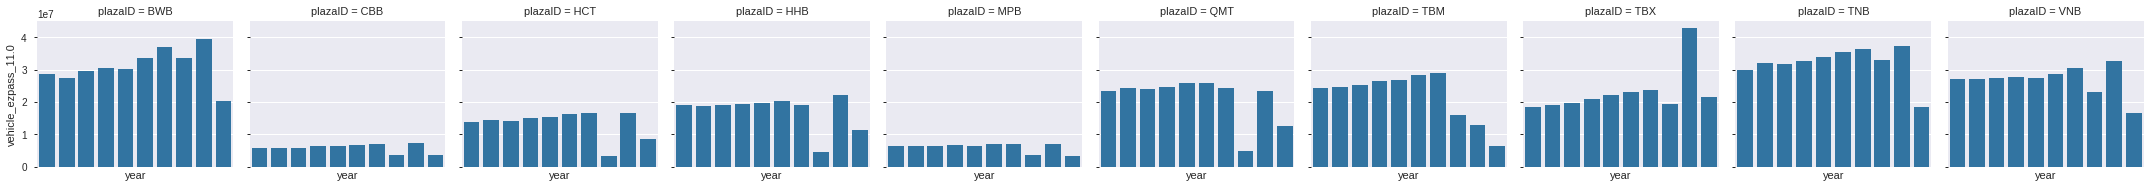

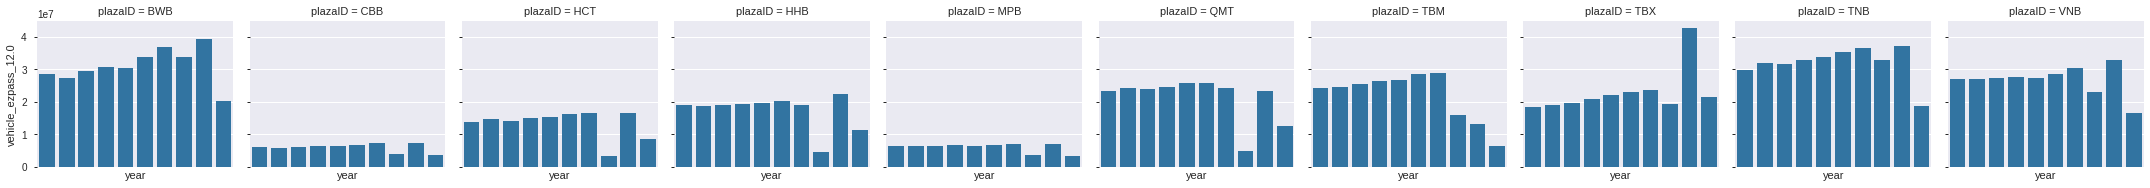

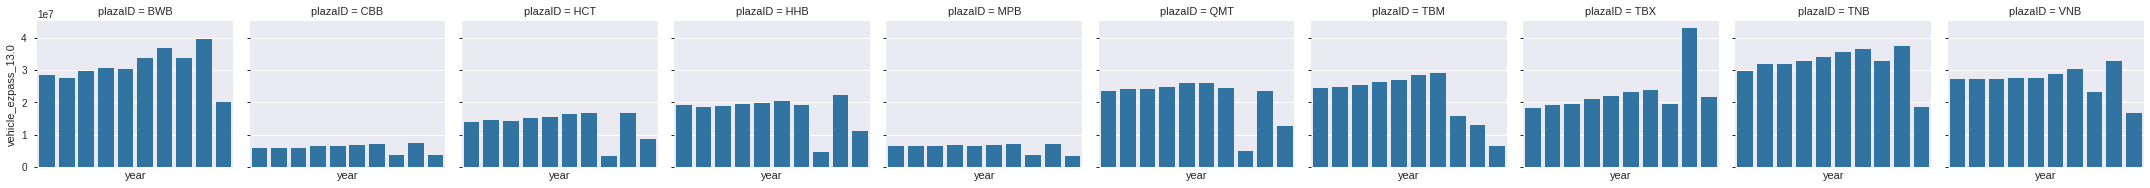

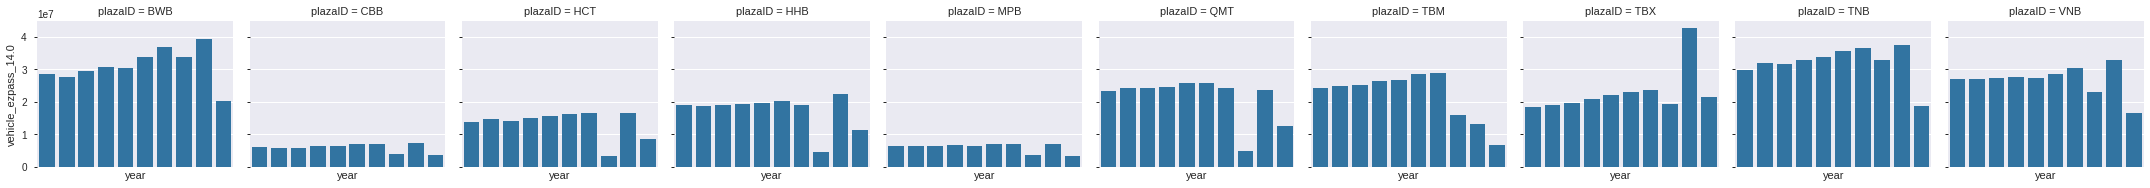

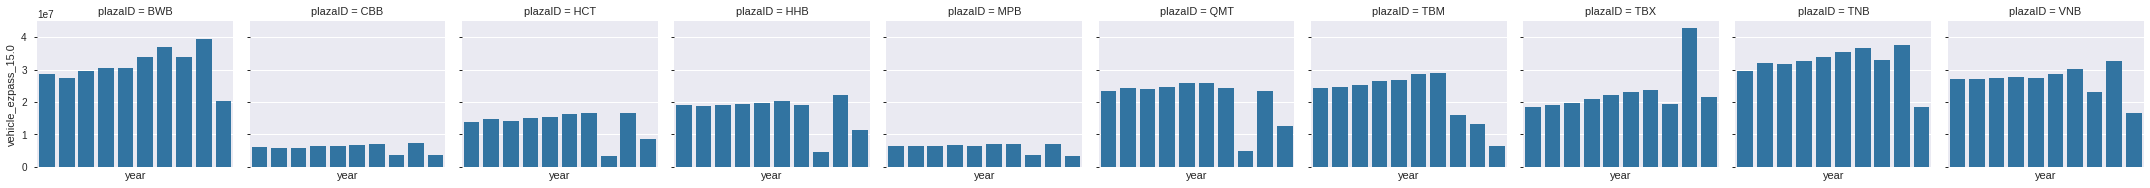

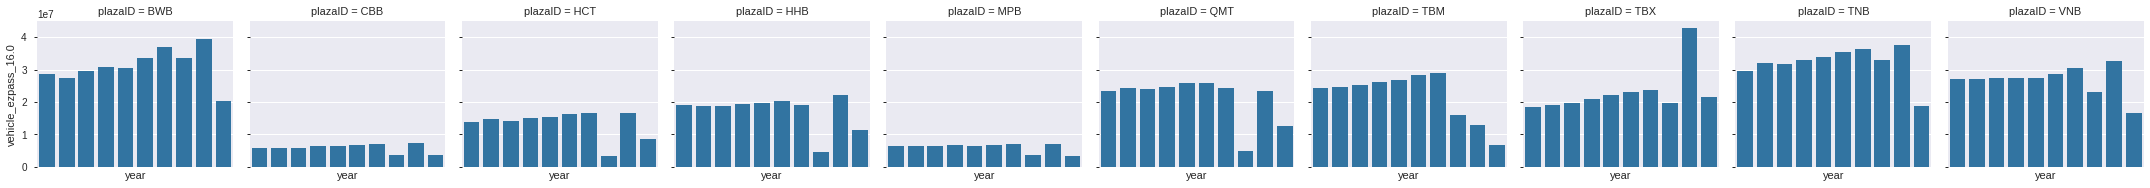

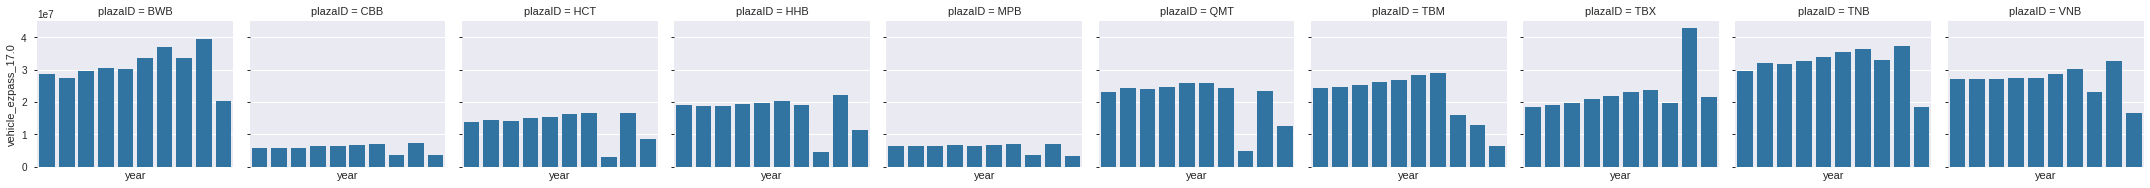

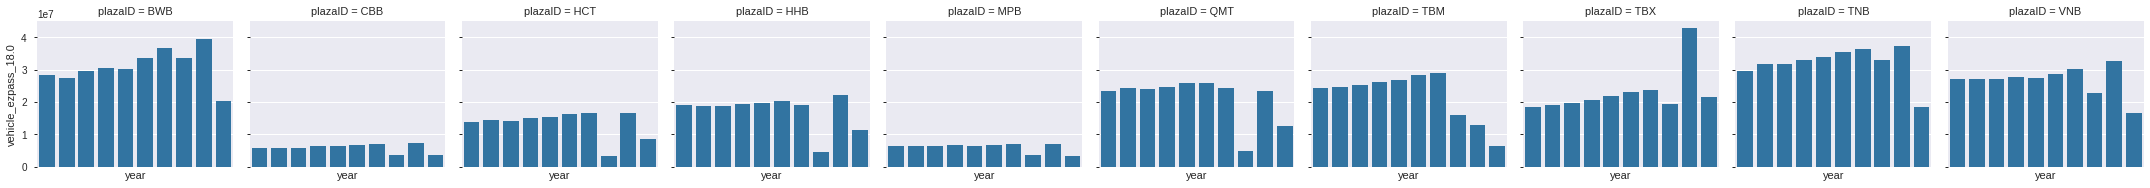

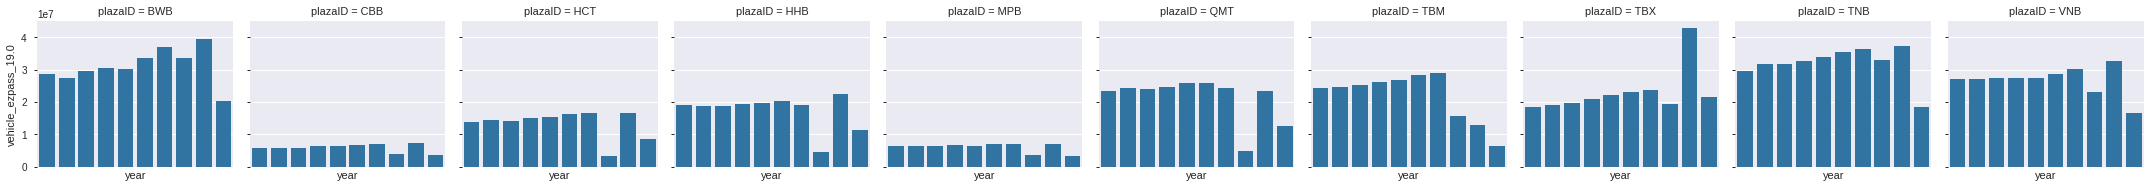

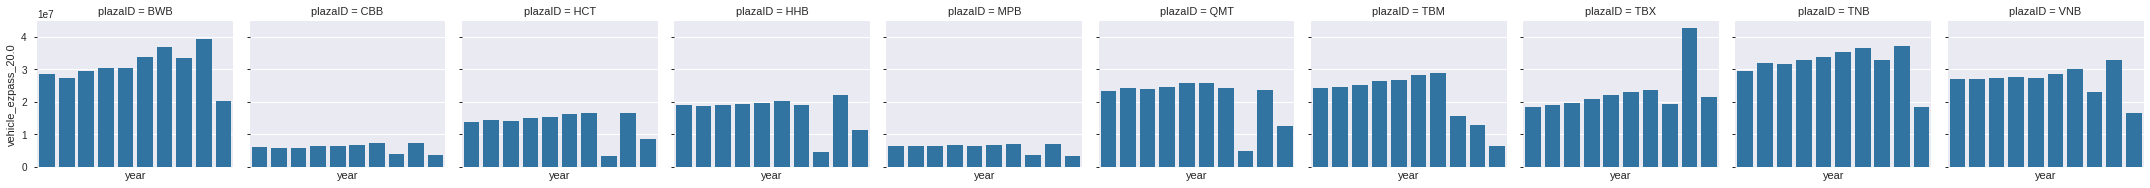

In [24]:
# Let's see how different the estimated vehicle volume with simulated fares compares to the original volume of vehicles of EZ pass

# remap the Plaza ID's to their original value
nyc_traffic_data['plazaID'] = encoder_plazaID.inverse_transform(plazaID_temp)

# remap the direction to their original value 0 = Inbound 1 = Outbound
#nyc_traffic_data['Direction'] = encoder_direction.inverse_transform(nyc_traffic_data['Direction'])

simulated_vehicle_volume = nyc_traffic_data.groupby(['plazaID', 'year'])[[
    'n_vehicles_ezpass',
    'vehicle_ezpass_4.0',
    'vehicle_ezpass_5.0',
    'vehicle_ezpass_6.0',
    'vehicle_ezpass_7.0',
    'vehicle_ezpass_8.0',
    'vehicle_ezpass_9.0',
    'vehicle_ezpass_10.0',
    'vehicle_ezpass_11.0',
    'vehicle_ezpass_12.0',
    'vehicle_ezpass_13.0',
    'vehicle_ezpass_14.0',
    'vehicle_ezpass_15.0',
    'vehicle_ezpass_16.0',
    'vehicle_ezpass_17.0',
    'vehicle_ezpass_18.0',
    'vehicle_ezpass_19.0',
    'vehicle_ezpass_20.0']].sum().reset_index()

# plot the data and see how it compares to the original vehicle ezpass volume
for fareprice in simulated_vehicle_volume.columns[2:]:
    g = sns.FacetGrid(simulated_vehicle_volume, col="plazaID")
    g.map(sns.barplot, 'year', fareprice)
    g.set(xticks=[])

The above plots show the total EZ pass vehicles for each bridge/tunnel over the 2010-2019 year.

## Conclusion

- We see that even with these preview rows, that the prices don't much increase or decrease that much. 

- Makes some sense as even though fares go up, vehicle traffic is still high and many commuters who have no choice but to go though a tunnel or bridge toll do it regardless to get to their destination.

- Some thoughts to consider in this situation
        
    - Perhaps more data could have been retrieved or used a different dataset
          
    - Adding features such as CO2 emissions, weather and, vehicle type and model
          
    - Using a different model or even an unsupervised algorithm.